evaluate iteration: 151
improve iteration: 1


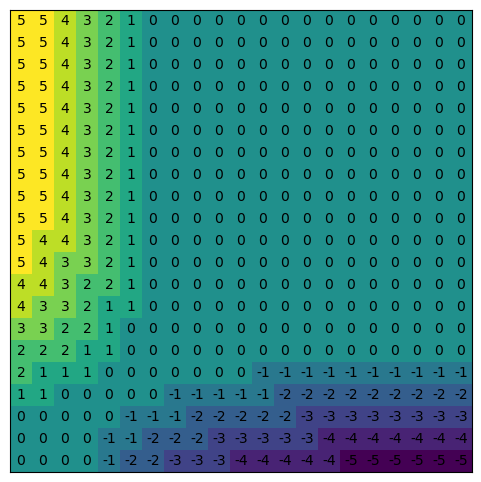

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import profile

max_num_cars = 20
grid_size = max_num_cars + 1 
num_states = grid_size * grid_size
invalid_state = num_states
e_rental_1 = 3
e_rental_2 = 4
e_return_1 = 3
e_return_2 = 2
max_moving = 5
num_actions = max_moving * 2 + 1
per_rental_reward = 10.0
per_moving_reward = -2.0


action_state_transition = np.zeros((num_states,num_actions,num_states),dtype=float)
action_reward = np.zeros((num_states,num_actions),dtype=float)


def poisson(lam, k):
    return math.pow(lam, k) * math.exp(-lam) / math.factorial(k)

def poissons(lam, num):
    res = np.arange(num, dtype=float)
    for k in range(num):
        res[k] = poisson(lam, k)
    return res

def calc_rental_reward(probs, num_car):
    return (np.sum(probs[:num_car]*np.arange(num_car)) + np.sum(probs[num_car:]) * num_car) * per_rental_reward

def morning_to_night_state_transition(morning_car_num, prob_rental, prob_return):
    new_state = np.zeros(grid_size)
    for num_rental in range(grid_size):
        new_car_num =  max(morning_car_num - num_rental, 0)
        for num_return in range(grid_size):
            new_car_num =  min(new_car_num + num_rental, max_num_cars)
            new_state[new_car_num] += prob_rental[num_rental] * prob_return[num_return]
    return new_state

def init_env():
    prob_rental_1 = poissons(e_rental_1, grid_size)
    prob_rental_2 = poissons(e_rental_2, grid_size)
    prob_return_1 = poissons(e_return_1, grid_size)
    prob_return_2 = poissons(e_return_2, grid_size)
    
    for state in range(num_states):
        car_num1 = state // grid_size
        car_num2 = state % grid_size
        for action in range(num_actions):
            num_moving = action - 5
            moving_reward = abs(num_moving) * per_moving_reward
            if num_moving >= 0:
                real_num_moving = min(car_num1, num_moving)
            else:
                real_num_moving = -min(car_num2, -num_moving)
                
            morning_car_num1 = min(car_num1 - real_num_moving, max_num_cars)
            morning_car_num2 = min(car_num2 + real_num_moving, max_num_cars)
            rental_reward1 = calc_rental_reward(prob_rental_1, morning_car_num1)
            rental_reward2 = calc_rental_reward(prob_rental_2, morning_car_num2)
            action_reward[state][action] = moving_reward + rental_reward1 + rental_reward2
            
            new_state1 = morning_to_night_state_transition(morning_car_num1, prob_rental_1, prob_return_1)
            new_state2 = morning_to_night_state_transition(morning_car_num2, prob_rental_2, prob_return_2)
            for new_state in range(num_states):
                new_car_num1 = new_state // grid_size
                new_car_num2 = new_state % grid_size
                action_state_transition[state][action][new_state] = new_state1[new_car_num1] * new_state2[new_car_num2]
            

'''xxx = set()
for s in action_state_transition.reshape(-1):
    xxx.add(s)
print(len(xxx))'''

def evaluate_policy(policy, gamma, threshold = 1e-5, max_iteration = 0x100000, inplace = True):
    values = np.zeros(num_states)
    if not inplace:
        new_values = np.zeros(num_states)
    for iteration in range(max_iteration):
        delta = 0.0
        for state in range(num_states):
            action = policy[state]
            reward = action_reward[state, action]
            state_prime_probs = action_state_transition[state, action]
            v_new = reward + gamma * (state_prime_probs * values).sum()
            delta = max(delta, abs(v_new - values[state]))
            if inplace:
                values[state] = v_new
            else:
                new_values[state] = v_new

        if not inplace:
            values, new_values = new_values, values #values = new_values.copy()#
        if delta <= threshold:
            break
    print("evaluate iteration:", iteration + 1 if max_iteration > 0 else 0)
    return values

def improve_policy(values, gamma):
    policy = np.zeros(num_states, dtype = int)
    for state in range(num_states):
        new_values = np.full(num_actions, float('-inf'))
        for action in range(num_actions):
            reward = action_reward[state, action]
            state_prime_probs = action_state_transition[state, action]
            new_values[action] = reward + gamma * (state_prime_probs * values).sum()
        policy[state] = new_values.argmax()
    return policy

def policy_iteration(num_iteration):
    policy = np.full(num_states, max_moving, dtype = int)
    for n in range(num_iteration):
        values = evaluate_policy(policy, 0.9, inplace = False)
        new_policy = improve_policy(values, 0.9)
        if (new_policy == policy).all():
            break
        policy = new_policy
    print("improve iteration:", n + 1 if num_iteration > 0 else 0)
    return policy

def show_policy(policy):
    show_policy = policy.reshape(grid_size,grid_size) - max_moving
    plt.rcParams['figure.figsize']=(6, 6)
    fig, ax  = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(show_policy, origin='lower')
    for y in range(grid_size):
        for x in range(grid_size):
            text = ax.text(x, y, f"{show_policy[y, x]}", ha="center", va="center", color=(0,0,0))

def show_values(values):
    plt.rcParams['figure.figsize']=(10, 10)
    fig, ax  = plt.subplots()
    values = values.reshape(grid_size, grid_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(values, origin='lower')
    for y in range(grid_size):
        for x in range(grid_size):
            text = ax.text(x, y, f"{values[y, x]:.1f}", ha="center", va="center", color=(0,0,0))

def test(n):
    policy = policy_iteration(n)
    show_policy(policy)
    #show_values(values)



init_env()
#for n in range(5):
#    test(n)
test(1)
